# GRU 모델 테스트 - 산업용
---

In [244]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from keras import Sequential
from keras.layers import LSTM, Conv1D, Dense, GRU
from keras.losses import Huber
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

## [1] 데이터 로딩
---

In [245]:
data_pre = pd.read_csv("./data/data_use.csv", index_col=0)
data_pred = pd.read_csv("./data/data_future.csv", index_col=0)
target = pd.read_csv("./data/target.csv", index_col=0)

# 데이터 병합
data = pd.concat([data_pre, data_pred], axis=0)
data = data.iloc[:468, ]

# 산업용 컬럼 추출
ind_cols = ["TEMP_EF", "POWER_GAS", "ELEC_IND_SUM", "OIL_PRICE", "QVA"]
data = data.loc[:, ind_cols]

# 산업용 타겟 추출
target = target.loc[:, ["IND"]]

In [246]:
data.head()

,TEMP_EF,POWER_GAS,ELEC_IND_SUM,OIL_PRICE,QVA
DATE,,,,,
1996-01-01,3.744768,8408979,9236808,27.86,36550.300000
1996-02-01,3.732234,7593086,8465308,29.04,36751.000000
1996-03-01,3.621268,8306941,9677322,27.99,36951.700000
1996-04-01,3.460496,8299351,9650845,28.74,37152.400000
1996-05-01,3.305460,8156027,9658045,29.18,37365.733333


In [247]:
target.head()

,IND
DATE,
1996-01-01,83809
1996-02-01,70427
1996-03-01,62652
1996-04-01,47050
1996-05-01,30709


## [2] 데이터 전처리
---

### [2-1] 데이터 정규화

In [248]:
# 스케일러 생성
data_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# 컬럼
cols = list(data.columns)

# fit
data_scaler.fit(data)
target_scaler.fit(target)

# transform
data_scaled = data_scaler.transform(data)
target_scaled = target_scaler.transform(target)

# to df
data_scaled = pd.DataFrame(data_scaled)
data_scaled.columns = cols

### [2-2] window 데이터셋 생성

In [249]:
def windowed_dataset(X, y, window_size, batch_size, shuffle):
    # X 값 window dataset 구성
    X_ds = tf.data.Dataset.from_tensor_slices(X)
    X_ds = X_ds.window(window_size, shift=1, stride=1, drop_remainder=True)
    X_ds = X_ds.flat_map(lambda x: x.batch(window_size))
    # y 값 추가
    y_ds = tf.data.Dataset.from_tensor_slices(y[window_size:])
    ds = tf.data.Dataset.zip((X_ds, y_ds))
    if shuffle:
        ds = ds.shuffle(80)
        
    return ds.batch(batch_size).prefetch(1)

In [250]:
def predict_dataset(X, window_size, batch_size):
    # X 값 window dataset 구성
    X_ds = tf.data.Dataset.from_tensor_slices(X)
    X_ds = X_ds.window(window_size, shift=1, stride=1, drop_remainder=True)
    X_ds = X_ds.flat_map(lambda x: x.batch(window_size))
        
    return X_ds.batch(batch_size).prefetch(1)

In [251]:
# 모델 파라미터
WINDOW_SIZE = 14
BATCH_SIZE = 32
INPUT_SHAPE = (WINDOW_SIZE, data.shape[1])

# 학습, 예측 데이터
data_train = data_scaled.iloc[:300, :]
data_pred = data_scaled.iloc[300-WINDOW_SIZE:, :]

# 데이터셋 생성
train_ds = windowed_dataset(
    data_train, target_scaled, WINDOW_SIZE, BATCH_SIZE, False
)

pred_ds = predict_dataset(
    data_pred, WINDOW_SIZE, BATCH_SIZE
)

## [3] 모델 생성
---

In [252]:
# 랜덤 시드 고정
tf.random.set_seed(42)

# LSTM 모델 생성
def make_model(filters, units, input_shape):
    model = Sequential(
        [
            Conv1D(
                filters=filters, kernel_size=3, activation="relu", input_shape=input_shape
            ),
            GRU(units*3, return_sequences=True),
            GRU(units*2, return_sequences=True),
            GRU(units*1),
            Dense(units, activation='relu'),
            Dense(1),
        ]
    )

    # loss: sequence에서 좋은 성능을 보여주는 Huber 사용
    loss = Huber()
    # optimizer: Adam 사용
    optimizer = Adam(0.0005)

    model.compile(optimizer=optimizer, loss=loss, metrics="mse")
    
    return model

In [253]:
model = make_model(32, 32, INPUT_SHAPE)
model.fit(train_ds, epochs=50, verbose=False)

## [4] 예측 시각화
---

In [254]:
pred = model.predict(pred_ds)

6/6 [==============================] - 1s 8ms/step


In [255]:
# 스케일 복구하기
inverse = target_scaler.inverse_transform(pred)
inverse = pd.DataFrame(list(inverse.reshape(-1, )), columns=["IND"])

In [256]:
# 결과값 생성
result = pd.concat([target, inverse]).reset_index(drop=True).iloc[:-1,]

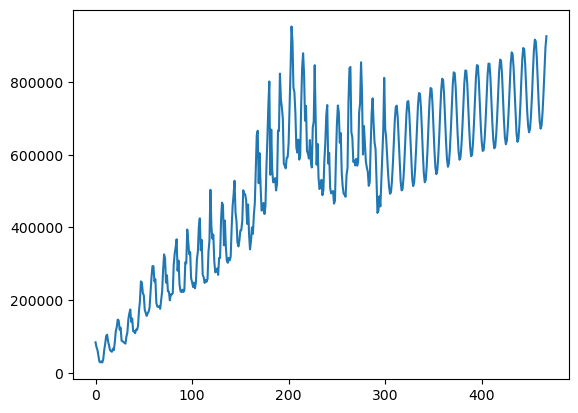

In [257]:
plt.plot(result);